In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("../../")
from TCN.soil_classification.model import SimpleVAE
from TCN.soil_classification.utils import data_generator, data_generator_test
from TCN.soil_classification.model_VAE import DenseVAE, ConvVAE
from TCN.soil_classification.model import TCN
from TCN.soil_classification.model_classifier import LatentClassifier
from sklearn.metrics import confusion_matrix
import time

from sklearn import metrics
from sklearn.manifold import TSNE

In [5]:
# Definitions for data indicies
LIN_ACC_X = 1
LIN_ACC_Y = 2
LIN_ACC_Z = 3
ANG_VEL_X = 4
ANG_VEL_Y = 5
ANG_VEL_Z = 6
ORIENT_X = 7
ORIENT_Y = 8
ORIENT_Z = 9
ORIENT_W = 10
POS_X = 11
POS_Z = 12
ANG = 13
BOOM = 14
DIPPER = 15
TELE = 16
PITCH = 17
labels = ["lin_acc_x","lin_acc_y","lin_acc_z","ang_vel_x","ang_vel_y","ang_vel_z", "ori_x", "ori_y",
          "ori_z", "ori_w", "pos_x", "pos_z", "ang", "boom", "dipper", "tele", "pitch"]

In [17]:
test_folder = "/home/mads/git/TCN/TCN/soil_classification/data/prelim_downsample_phase"
train_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/train"
val_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/test"


#class_model = "models_latent_class/latent_class6_3232_bs256_do0_seq128_imu_no_orient_phase2_nlf8/latent_class6_3232_bs256_do0_seq128_imu_no_orient_phase2_nlf8_ep78.pt"
#class_model = "models_latent_class/latent_class11_3232_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/latent_class11_3232_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep78.pt"
#class_model = "models_latent_class/latent_class_KL0045rel_3232_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/latent_class_KL0045rel_3232_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep80.pt"
class_model = "models_latent_class/latent_class_grad_3232_bs256_do0_seq128_imu_no_orient_derivative_phase2_nlf8/latent_class_grad_3232_bs256_do0_seq128_imu_no_orient_derivative_phase2_nlf8_ep80.pt"
#class_model = "models_latent_class/latent_class_norm_3232_bs256_do0_seq128_imu_no_orient_norm_phase2_nlf8/latent_class_norm_3232_bs256_do0_seq128_imu_no_orient_norm_phase2_nlf8_ep80.pt"
class_model_grad_norm = "models_latent_class/latent_class_3232_bs256_do0_seq128_imu_no_orient_norm_derivative_phase2_nlf8/latent_class_3232_bs256_do0_seq128_imu_no_orient_norm_derivative_phase2_nlf8_ep80.pt"

ConvVAE_8 = "AE_model/ConvVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/ConvVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep64.pt"
ConvVAE_8_2 = "AE_model/ConvVAE_KL0045rel_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/ConvVAE_KL0045rel_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep64.pt"
ConvVAED_8_grad = "AE_model/ConvVAED_Test14_bs256_do0_seq128_imu_no_orient_derivative_phase2_nlf8/ConvVAED_Test14_bs256_do0_seq128_imu_no_orient_derivative_phase2_nlf8_ep128.pt"
ConvVAED_8_norm = "AE_model/ConvVAED_Test13_bs256_do0_seq128_imu_no_orient_norm_phase2_nlf8/ConvVAED_Test13_bs256_do0_seq128_imu_no_orient_norm_phase2_nlf8_ep128.pt"
ConvVAED_8_norm_grad = "AE_model/ConvVAED_Test16_bs256_do25_seq128_imu_no_orient_norm_derivative_phase2_nlf8/ConvVAED_Test16_bs256_do25_seq128_imu_no_orient_norm_derivative_phase2_nlf8_ep128.pt"


ConvVAED_8 = "AE_model/ConvVAED_Test6_bs256_do0_seq128_imu_no_orient_phase2_nlf8/ConvVAED_Test6_bs256_do0_seq128_imu_no_orient_phase2_nlf8_ep128.pt"
#ConvVAED_8 = "AE_model/ConvVAED_Test11_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/ConvVAED_Test11_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep128.pt"
#TCN_model = "models_3/TCN_bs256_do0_seq128_imu_no_orient+torques_phase2/TCN_bs256_do0_seq128_imu_no_orient+torques_phase2_ep50.pt"
TCN_model = "models_3/TCN_bs256_do25_seq128_imu_no_orient_phase2/TCN_bs256_do25_seq128_imu_no_orient_phase2_ep40.pt"
TCN_model_acc = "models_3/TCN_bs256_do25_seq128_only_acceleration_phase2/TCN_bs256_do25_seq128_only_acceleration_phase2_ep40.pt"
TCN_model_grad = "models_3/TCN_bs256_do25_seq128_imu_no_orient_derivative_phase2/TCN_bs256_do25_seq128_imu_no_orient_derivative_phase2_ep12.pt"
TCN_model_norm = "models_3/TCN_bs256_do25_seq128_imu_no_orient_norm_phase2/TCN_bs256_do25_seq128_imu_no_orient_norm_phase2_ep40.pt"
TCN_model_aug = "models_3/TCN_bs256_do25_seq128_imu_no_orient_augment_phase2/TCN_bs256_do25_seq128_imu_no_orient_augment_phase2_ep40.pt"
TCN_model_augfull = "models_3/TCN_bs256_do25_seq128_imu_no_orient_augmentFull_phase2/TCN_bs256_do25_seq128_imu_no_orient_augmentFull_phase2_ep40.pt"
TCN_model_grad_norm = "models_3/TCN_bs256_do25_seq128_imu_no_orient_norm_derivative_phase2/TCN_bs256_do25_seq128_imu_no_orient_norm_derivative_phase2_ep6.pt"
TCN_model_8_norm_grad_t = "models_3/TCN_bs256_seed1_do25_seq128_imu_no_orient_norm_derivative+torque_phase2/TCN_bs256_seed1_do25_seq128_imu_no_orient_norm_derivative+torque_phase2_ep40.pt"


#variable_set = [list(range(LIN_ACC_X,ANG_VEL_Z+1,1))+list(range(BOOM,PITCH+1,1))]
variable_set = [list(range(LIN_ACC_X,ANG_VEL_Z+1,1))]
#variable_set = [list(range(LIN_ACC_X,LIN_ACC_Z+1,1))]

seq_len = 128
#seq_len = 100
phase = 2

X_train, Y_train = data_generator(train_folder, seq_len, seq_len-1, phase =phase, val_mask=variable_set[0])
X_test, Y_test, plotting, files = data_generator_test(val_folder, seq_len, seq_len-1, phase =phase, val_mask=variable_set[0])

#mask = Y_test > 0
#X_test, Y_test = X_test[mask], Y_test[mask]


norm = True
derivative = False
seq_standard = False
if norm:
    X_train[:,:,0] = torch.linalg.norm(X_train[:,:,0:3], dim = 2)
    X_train[:,:,1] = torch.linalg.norm(X_train[:,:,3:6], dim = 2)
    X_train = X_train[:,:,[0,1]+list(range(6,X_train.shape[2],1))]

if derivative:
    X_train = torch.from_numpy(np.gradient(X_train, axis=1))
    
if seq_standard:
    m = X_train.mean(axis=1).unsqueeze(1)
    s = X_train.std(axis=1).unsqueeze(1)
    X_train -= m
    X_train /= s

    
m = X_train.mean(0, keepdim=True)
s = X_train.std(0, unbiased=False, keepdim=True)

X_train -= m
X_train /= s
X_train = X_train.permute(0,2,1)

for traj_idx in range(len(X_test)):
    if norm:
        X_test[traj_idx][:,:,0] = torch.linalg.norm(X_test[traj_idx][:,:,0:3], dim = 2)
        X_test[traj_idx][:,:,1] = torch.linalg.norm(X_test[traj_idx][:,:,3:6], dim = 2)
        X_test[traj_idx] = X_test[traj_idx][:,:,[0,1]+list(range(6,X_test[traj_idx].shape[2],1))]
        
    if derivative:
            X_test[traj_idx] = torch.from_numpy(np.gradient(X_test[traj_idx], axis=1))

    if seq_standard:
        m = X_test[traj_idx].mean(axis=1).unsqueeze(1)
        s = X_test[traj_idx].std(axis=1).unsqueeze(1)
        X_test[traj_idx] -= m
        X_test[traj_idx] /= s
    X_test[traj_idx] -= m
    X_test[traj_idx] /= s
    X_test[traj_idx] = X_test[traj_idx].permute(0,2,1)

channel_sizes = [30]*8 #[30,30,30,30,30,4]#[30]*6 #[30,20,10,1]#
kernel_size = 7
input_channels = X_train.shape[1]
latent_dim = 8

n_classes = 4
classifier_hidden_dims = [32,32]
    
#back_model = ConvVAE(input_channels, channel_sizes, kernel_size)
#back_model.load_state_dict(torch.load(ConvVAED_8_norm_grad))

#model = LatentClassifier(back_model, latent_dim, classifier_hidden_dims, n_classes, VAE=True, dropout=0.35)
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size , dropout=0.2)

model.load_state_dict(torch.load(TCN_model))
model.eval()

RuntimeError: Error(s) in loading state_dict for TCN:
	size mismatch for tcn.network.0.conv1.weight_v: copying a param with shape torch.Size([30, 6, 7]) from checkpoint, the shape in current model is torch.Size([30, 2, 7]).
	size mismatch for tcn.network.0.net.0.weight_v: copying a param with shape torch.Size([30, 6, 7]) from checkpoint, the shape in current model is torch.Size([30, 2, 7]).
	size mismatch for tcn.network.0.downsample.weight: copying a param with shape torch.Size([30, 6, 1]) from checkpoint, the shape in current model is torch.Size([30, 2, 1]).

In [15]:
with torch.no_grad():
    model.eval()
    output = []
    for x in X_test:
        output.append(model(x))

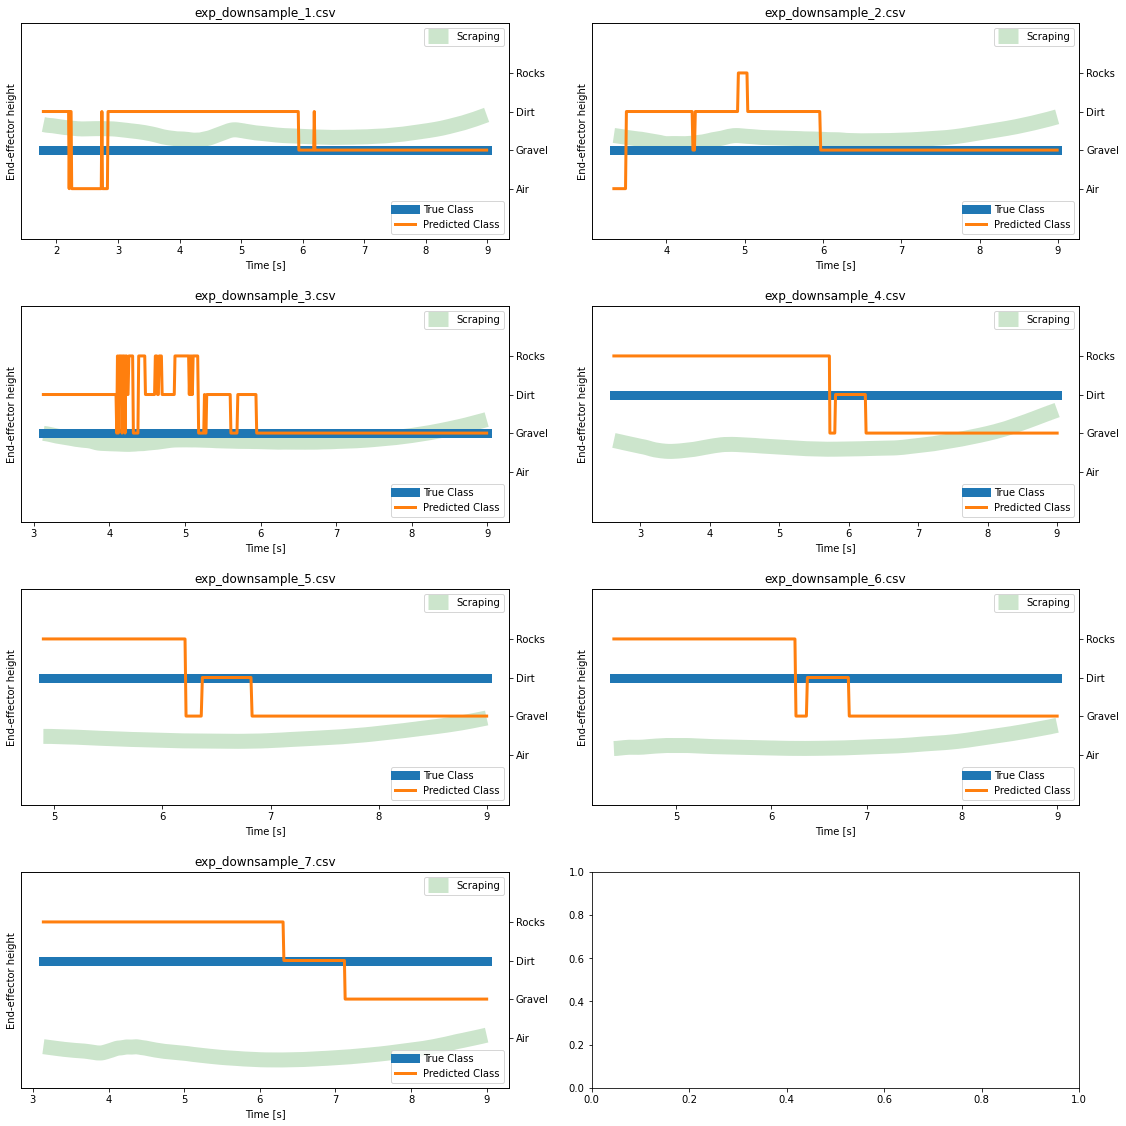

In [16]:
rows = int((len(plotting)+1)/2)
colors = ["r","g","b"]
yticks = ['Air','Gravel','Dirt','Rocks']
y_nums = np.array([0,1,2,3])
phases = ["Penetration", "Scraping", "Lifting"]

fig, ax1 = plt.subplots(rows,2,figsize = [16,4*rows])
ax2 = np.empty_like(ax1)
for a1,a2,d,f,y,out in zip(ax1.reshape(-1),ax2.reshape(-1),plotting,files, Y_test,output):
    a2 = a1.twinx()
    a1.title.set_text(f)
    a1.set_ylim([-1, 1])
    a2.set_ylim([-1.3, 4.3])
    plt.yticks(y_nums,yticks)
    a1.axes.get_yaxis().set_ticks([])
    a1.set_xlabel("Time [s]")
    a1.set_ylabel("End-effector height")

    out = np.argmax(out.numpy(),axis=1)

    for phase in np.unique(d[:,-1]):
        a1.plot(d[d[:,-1]==phase,0],d[d[:,-1]==phase,2],color=colors[int(phase)-1],
                    linewidth=15, alpha=0.2, label = phases[int(phase)-1], solid_capstyle='butt')

    a2.plot(d[:,0],y, linewidth=9, label="True Class")
    a2.plot(d[:,0],out, linewidth=3, label="Predicted Class")
    a1.legend(loc=1)
    a2.legend(loc=4)
fig.tight_layout(pad=2.0)
plt.show()

#plt.savefig(name+".pdf", dpi=150)
#plt.close()

In [21]:
X_test[0][0,:,:]

tensor([[1.0176e+01, 1.0011e+01, 9.9258e+00, 9.9115e+00, 9.8830e+00, 9.7350e+00,
         9.5999e+00, 9.5524e+00, 9.4763e+00, 9.4222e+00, 9.4204e+00, 9.4303e+00,
         9.5466e+00, 9.6161e+00, 9.7111e+00, 9.8929e+00, 1.0075e+01, 1.0241e+01,
         1.0385e+01, 1.0430e+01, 1.0331e+01, 1.0099e+01, 9.7643e+00, 9.5953e+00,
         9.5660e+00, 9.5626e+00, 9.6687e+00, 9.4286e+00, 9.2971e+00, 9.2969e+00,
         8.7140e+00, 9.7749e+00, 9.4281e+00, 9.7617e+00, 1.0312e+01, 1.0280e+01,
         9.6502e+00, 9.8256e+00, 9.8104e+00, 9.5910e+00, 9.9908e+00, 9.9764e+00,
         1.0398e+01, 1.0044e+01, 1.0368e+01, 9.9907e+00, 1.0225e+01, 9.5189e+00,
         9.3840e+00, 9.2733e+00, 9.3197e+00, 9.6467e+00, 1.0028e+01, 1.0325e+01,
         1.0471e+01, 1.0702e+01, 1.0152e+01, 9.9059e+00, 9.6261e+00, 9.5865e+00,
         9.4462e+00, 9.6195e+00, 1.0045e+01, 9.7949e+00, 9.5446e+00, 9.3715e+00,
         9.6358e+00, 9.9670e+00, 1.0266e+01, 1.0459e+01, 1.0302e+01, 1.0037e+01,
         9.9258e+00, 9.7445e